### Imports

In [425]:
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
import time

### Obtain and Prepare Data

In [426]:
start = datetime.strptime('2020-01-02','%Y-%m-%d')
end = datetime.strptime('2022-02-28','%Y-%m-%d')

df = data.DataReader('EURUSD=X',start=start, end=end, data_source='yahoo')
df = df[:1500]['Close']

In [427]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(np.array(df).reshape(-1,1))

In [428]:
training_size=int(len(data)*0.65)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:]

In [429]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [430]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [431]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

### Build and Train LSTM

In [432]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [433]:
model=Sequential() 
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1))) 
model.add(LSTM(50,return_sequences=True)) 
model.add(LSTM(50)) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',optimizer='adam')

In [434]:
start= time.time()
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)
end=time.time()

Epoch 1/100
5/5 [==============================] - 9s 540ms/step - loss: 0.3890 - val_loss: 0.0184
Epoch 2/100
5/5 [==============================] - 1s 144ms/step - loss: 0.0486 - val_loss: 0.0907
Epoch 3/100
5/5 [==============================] - 1s 182ms/step - loss: 0.0271 - val_loss: 0.0034
Epoch 4/100
5/5 [==============================] - 1s 136ms/step - loss: 0.0265 - val_loss: 0.0040
Epoch 5/100
5/5 [==============================] - 1s 142ms/step - loss: 0.0113 - val_loss: 0.0309
Epoch 6/100
5/5 [==============================] - 1s 154ms/step - loss: 0.0115 - val_loss: 0.0384
Epoch 7/100
5/5 [==============================] - 1s 180ms/step - loss: 0.0076 - val_loss: 0.0145
Epoch 8/100
5/5 [==============================] - 1s 161ms/step - loss: 0.0069 - val_loss: 0.0136
Epoch 9/100
5/5 [==============================] - 1s 145ms/step - loss: 0.0062 - val_loss: 0.0211
Epoch 10/100
5/5 [==============================] - 1s 144ms/step - loss: 0.0057 - val_loss: 0.0243
Epoch 11/

5/5 [==============================] - 1s 170ms/step - loss: 0.0026 - val_loss: 0.0059
Epoch 84/100
5/5 [==============================] - 1s 179ms/step - loss: 0.0025 - val_loss: 0.0051
Epoch 85/100
5/5 [==============================] - 1s 186ms/step - loss: 0.0025 - val_loss: 0.0065
Epoch 86/100
5/5 [==============================] - 1s 252ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 87/100
5/5 [==============================] - 1s 238ms/step - loss: 0.0026 - val_loss: 0.0064
Epoch 88/100
5/5 [==============================] - 1s 186ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 89/100
5/5 [==============================] - 1s 150ms/step - loss: 0.0027 - val_loss: 0.0068
Epoch 90/100
5/5 [==============================] - 1s 164ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 91/100
5/5 [==============================] - 1s 143ms/step - loss: 0.0025 - val_loss: 0.0063
Epoch 92/100
5/5 [==============================] - 1s 153ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 93/100


### Make Predictions

In [435]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Visualize Results

<function matplotlib.pyplot.show(close=None, block=None)>

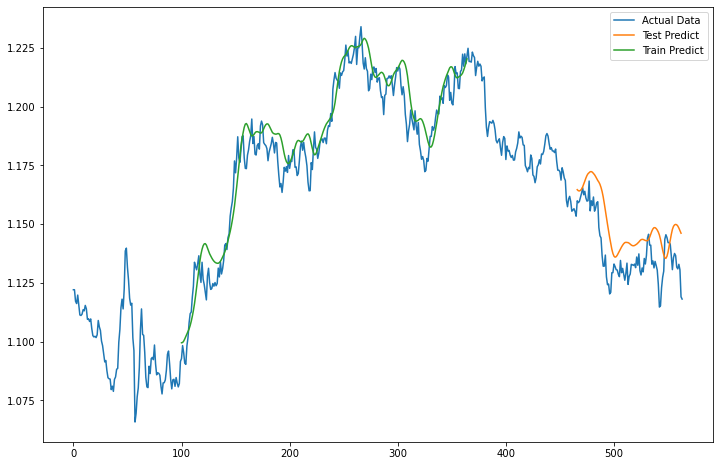

In [436]:
look_back=time_step
trainPredictPlot=np.empty_like(data)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

testPredictPlot=np.empty_like(data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1,:] = test_predict

plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)
plt.legend(['Actual Data','Test Predict','Train Predict'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

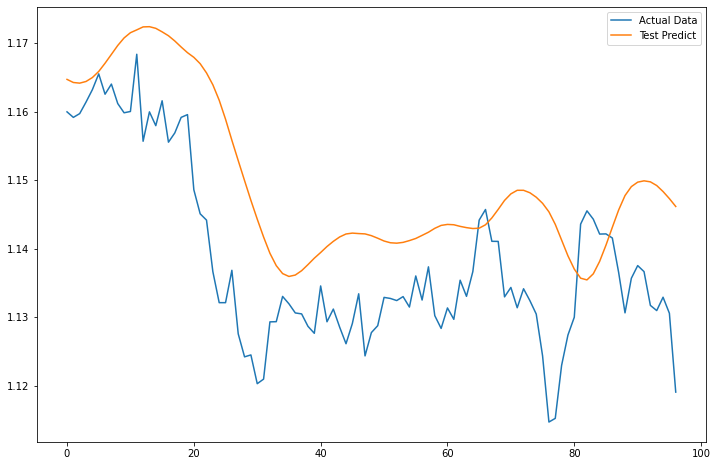

In [437]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(data)[len(train_predict)+(look_back*2)+1:len(data)-1])
plt.plot(test_predict)
plt.legend(['Actual Data','Test Predict'])
plt.show

### Evaluation

In [438]:
from sklearn.metrics import mean_squared_error
test_predict=model.predict(X_test)
print('MSE:',mean_squared_error(y_test, test_predict))

MSE: 0.007045719371697432


In [439]:
print('Coefficient of Variation:',df.std()/df.mean())

Coefficient of Variation: 0.03592553730685507


In [440]:
print('Time taken for training in seconds:',end-start)

Time taken for training in seconds: 90.48284268379211
